In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [2]:
# data
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
num_epochs = 1  # train for at least 50 epochs for good results
image_size = 64
# # KID = Kernel Inception Distance, see related section
# kid_image_size = 75
# kid_diffusion_steps = 5
# plot_diffusion_steps = 20

# sampling
# min_signal_rate = 0.02
# max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

In [3]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

In [4]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(64, 64, 64, 3), dtype=tf.float32, name=None)>

In [5]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling, it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return {"image": tf.clip_by_value(image / 255.0, 0.0, 1.0), "label": data["label"]}


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

# Convert the datasets to NumPy format
train_data_np = tfds.as_numpy(train_dataset)
val_data_np = tfds.as_numpy(val_dataset)

# Extract images (X) and labels (Y) from train and validation datasets
X_train = []
Y_train = []
X_test = []
Y_test = []

for batch in train_data_np:
    images = batch['image']
    labels = batch['label']
    X_train.extend(images)
    Y_train.extend(labels)

for batch in val_data_np:
    images = batch['image']
    labels = batch['label']
    X_test.extend(images)
    Y_test.extend(labels)

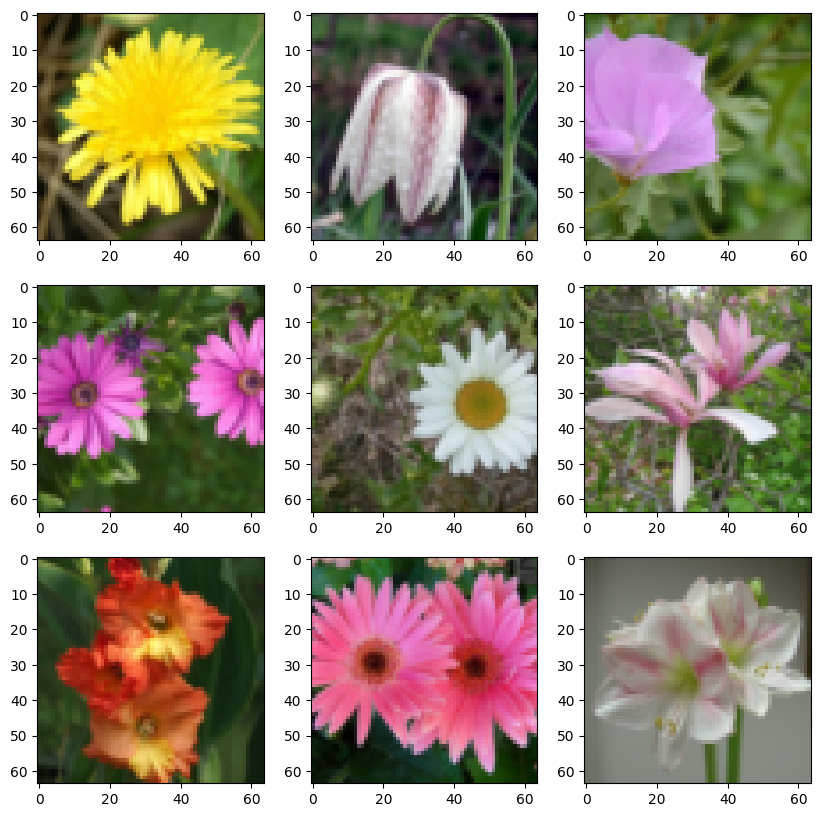

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for i in range(9):
    # define subplot
    plt.subplot(3, 3, i+1)
    # plot raw pixel data
    plt.imshow(X_train[i])

# show the figure
plt.show()


In [7]:
import numpy as np

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)


In [8]:
def create_vgg_net(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    base_model = VGG16(input_tensor=input_layer, include_top=False, weights=None)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [9]:
input_shape = (image_size, image_size, 3)
num_classes = len(np.unique(Y_train))

model_vgg = create_vgg_net(input_shape, num_classes)


In [10]:
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [11]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [13]:
hist_vgg = model_vgg.fit(X_train, Y_train, epochs=20, batch_size=batch_size, validation_data=(X_test, Y_test))

Epoch 1/20
511/511 [==============================] - 44s 87ms/step - loss: 4.5155 - accuracy: 0.0315 - val_loss: 4.5270 - val_accuracy: 0.0240
Epoch 2/20
511/511 [==============================] - 45s 88ms/step - loss: 4.5023 - accuracy: 0.0326 - val_loss: 4.5237 - val_accuracy: 0.0240
Epoch 3/20
511/511 [==============================] - 43s 83ms/step - loss: 4.5011 - accuracy: 0.0333 - val_loss: 4.5240 - val_accuracy: 0.0274
Epoch 4/20
511/511 [==============================] - 42s 82ms/step - loss: 4.5007 - accuracy: 0.0332 - val_loss: 4.5234 - val_accuracy: 0.0274
Epoch 5/20
511/511 [==============================] - 44s 87ms/step - loss: 4.5005 - accuracy: 0.0332 - val_loss: 4.5257 - val_accuracy: 0.0274
Epoch 6/20
511/511 [==============================] - 44s 87ms/step - loss: 4.5001 - accuracy: 0.0330 - val_loss: 4.5253 - val_accuracy: 0.0240
Epoch 7/20
511/511 [==============================] - 42s 82ms/step - loss: 4.5001 - accuracy: 0.0322 - val_loss: 4.5252 - val_accuracy:

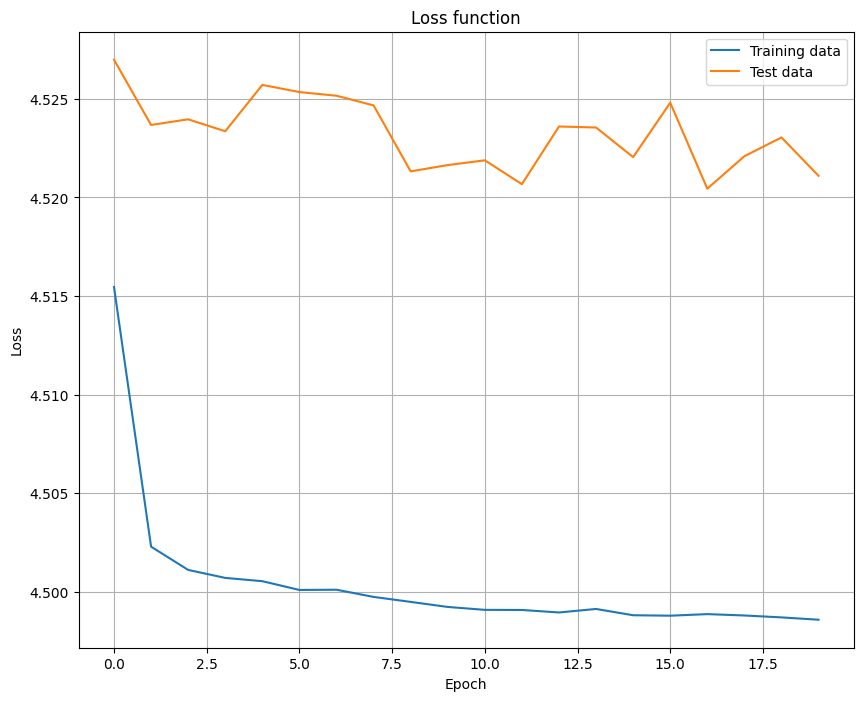

In [14]:
fig = plt.figure(figsize=(10,8))
plt.plot(hist_vgg.history['loss'])
plt.plot(hist_vgg.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Test data'])
plt.show()

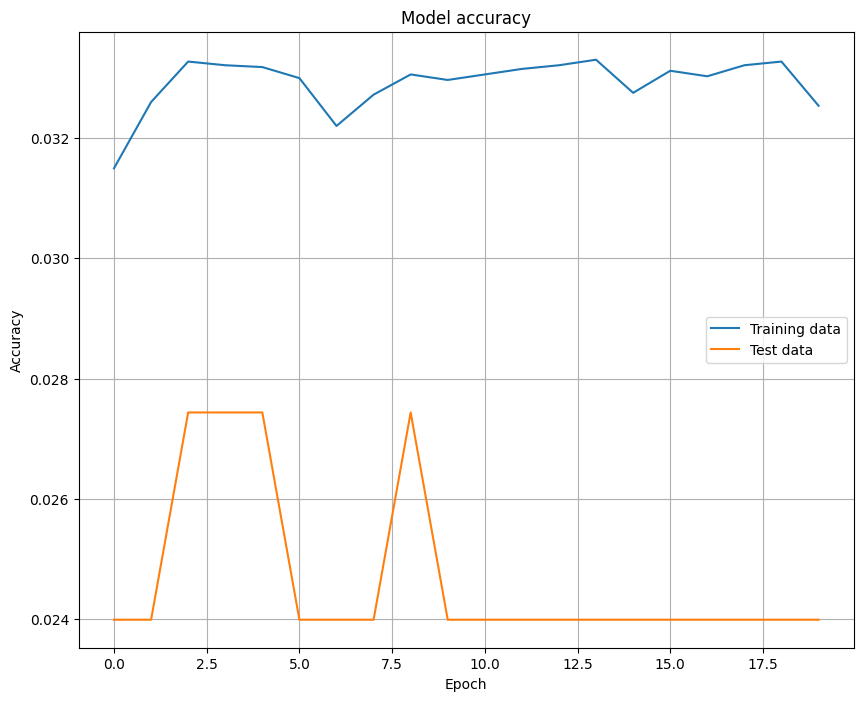

In [15]:
fig = plt.figure(figsize=(10,8))
plt.plot(hist_vgg.history['accuracy'])
plt.plot(hist_vgg.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Training data', 'Test data'])

In [16]:
loss, accuracy = model_vgg.evaluate(X_test, Y_test, batch_size=batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

127/127 [==============================] - 3s 24ms/step - loss: 4.5211 - accuracy: 0.0240
Test Loss: 4.521099090576172
Test Accuracy: 0.023991141468286514


The accuracy is so low in VGG16 Model.